<a href="https://colab.research.google.com/github/Hitesh1912/Dog-Breed-Classifier-using-Pytorch/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cite: https://github.com/UsmanIjaz/deep-learning-dog-breed-classification

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
cd /content/drive/My Drive/Deep_Learning_Projects/Dog_Breed_Classification_PyTorch

/content/drive/My Drive/Deep_Learning_Projects/Dog_Breed_Classification_PyTorch


In [0]:
input_folder='/content/drive/My Drive/Deep_Learning_Projects/Dog_Breed_Classification_PyTorch'


***We break the notebook into separate steps. Feel free to use the links below to navigate the notebook.***


* Step 0: Import Datasets
* Step 1: Detect Humans
* Step 2: Detect Dogs
* Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
* Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
* Step 5: Write your Algorithm
* Step 6: Test Your Algorithm





In [0]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from keras.utils import plot_model

from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from glob import glob
import os
import json

import seaborn as sns
import pandas as pd
import numpy as np

import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline 

In [0]:
# !unzip '/content/drive/My Drive/Deep_Learning_Projects/Dog_Breed_Classification_PyTorch/dog_images/dogImages.zip'

In [0]:
# Following code is used to generate a json file with catergory_id as the key and category_name as value


#path = 'dogImages/train'
#cat_to_name = {} 
#files = os.listdir(path)
#for name in files:
#    row = name.split(".")
#    cat_to_name[str(int(row[0]))] = row[1]

#with open('cat_to_name.json', 'w') as outfile:  
#    json.dump(cat_to_name, outfile)
 

In [5]:
pwd

'/content/drive/My Drive/Deep_Learning_Projects/Dog_Breed_Classification_PyTorch'

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
# load filenames for human and dog images
# human_files = np.array(glob("/data/lfw/*/*"))

dog_files = np.array(glob("data/dogImages/*/*/*.jpg"))

# print number of images in each dataset
# print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [0]:
dog_files_short = np.array(glob("data/dogImages/test/*/*.jpg"))
# dog_files_short

---
<a id='step1'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.4MB/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

In [8]:
use_cuda

True

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
def VGG16_predict(image_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    # Turn the input into a Variable
    if use_cuda:
        image = Variable(image_tensor.cuda())
    
    VGG16.eval()
    # Predict the class of the image
    output = VGG16(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return index


In [12]:
VGG16_predict(dog_files_short[10])

160

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


data_dir = 'data/dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [0]:
data_transforms = {
    'train' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [0]:
image_datasets = {
    'train' : ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid' : ImageFolder(root=valid_dir,transform=data_transforms['valid']),
    'test' : ImageFolder(root=test_dir,transform=data_transforms['test']),
}

In [0]:
data_loaders = {
    'train' : DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : DataLoader(image_datasets['valid'],batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'],batch_size = batch_size)    
}

In [17]:
print("Size of training set is: "+str(len(image_datasets['train'])))
print("Size of validation set is: "+str(len(image_datasets['valid'])))
print("Size of testing set is: "+str(len(image_datasets['test'])))

Size of training set is: 6680
Size of validation set is: 835
Size of testing set is: 836


In [18]:
print("Number of classes are: "+str(len(image_datasets['train'].classes)))

Number of classes are: 133


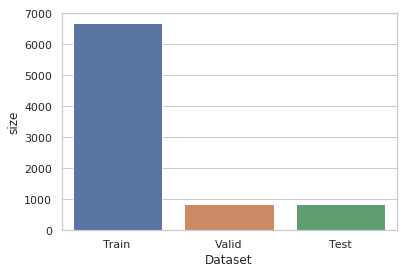

In [15]:
data_size = [['Train',len(image_datasets['train'])],['Valid',len(image_datasets['valid'])],['Test',len(image_datasets['test'])]]
df = pd.DataFrame(data_size,columns=['Dataset','size'])

sns.set(style="whitegrid")
ax = sns.barplot(x="Dataset", y="size", data=df)

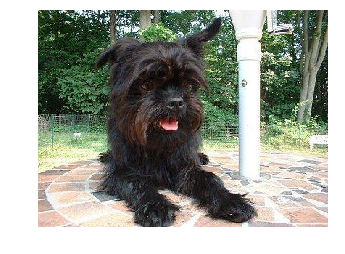

In [37]:
plt.axis('off')
plt.imshow(plt.imread(image_datasets['train'].imgs[0][0]))

In [0]:
path = 'data/dogImages/train'
images = []
titles = []
files = os.listdir(path)
for name in files:
    row = name.split(".")
    all_images = os.listdir(path+'/'+name)
    image = plt.imread(path+'/'+name+'/'+all_images[0])
    images.append(image)
    titles.append(row[1])
    continue


In [0]:

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.set_axis_off()
        plt.axis('off')
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [0]:
# show_images(images[:6], 3, titles[:6])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- I resized the image to 224x224. I used all color channels for the image. Input tensor is 224x224x3.
- Yes, I augmented the training set by flipping the images horizontally and 10 degree of rotation. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)

        self.fc1 = nn.Linear(256 * 6 * 6, 133)
        
        self.max_pool = nn.MaxPool2d(2, 2,ceil_mode=True)
        self.dropout = nn.Dropout(0.2)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.conv_bn2(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.conv_bn3(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.conv_bn4(x)
        
        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.conv_bn5(x)
        
        x = F.relu(self.conv5(x))
        x = self.max_pool(x)
        x = self.conv_bn6(x)
        
        x = x.view(-1, 256 * 6 * 6)
        
        x = self.dropout(x)
        x = self.fc1(x)


        return x

# instantiate the CNN
model = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

In [0]:
#display model architecture


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- I used the six convolution layers all with the colvolution of size = 3, stride = 1 and padding = 0
- Relu activations are used after each convoltution layers except the last one.
- Max pooling layers of 2*2 are applied.
- Batch normalization is applied after each max pool layer. 
- Dropout is applied with the probability of 0.2.

These choices are made after following an iterative process of improving validation accuracy and best practices discussed in the different papers.  

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

## Metrics
- Accuracy: Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Our probllem is a classificaition problem so measuring accuracy is important. 
- Loss: Loss is calculated for all three datasets to check if the model is underfitting/overfitting or not.If our training loss is much lower than validation loss then this means the network might be overfitting. Solutions to this are to decrease our network size, or to increase dropout. If training loss << validation loss , it is overfitting; if roughly training loss = validation loss , it is underfitting.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
def train(n_epochs, loaders, model, optimizer,scheduler, criterion, use_cuda, save_path):
    '''
    trains the model according to given parameters
    
    Args:
        n_epochs: Number of epochs
        loaders: data loaders
        model: model to be trained
        optimizer: optimizer needed to train the model
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        save_path: path to save the model 
        
    Returns:
        returns trained model
    '''  
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        scheduler.step()
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model

In [0]:
%%time
# train the model
loaders = data_loaders
n_epochs = 20

## Please uncomment the two lines below to train the model. 
model_scratch = train(n_epochs, loaders, model, optimizer_scratch,exp_lr_scheduler, 
                     criterion_scratch, use_cuda, 'model.pt')

# load the model that got the best validation accuracy
# model.load_state_dict(torch.load('model.pt'))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):
    '''
    trains the model according to given parameters
    
    Args:
        loaders: data loaders
        model: model to be trained
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        
    Returns:
        print test loss and test accuracy
    '''  

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.755636


Test Accuracy: 26% (219/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
# using the Data Loaders created above

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [0]:
model_transfer = models.resnet18(pretrained=True)
print(model_transfer)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 86238188.64it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for param in model_transfer.parameters():
    param.requires_grad = False


num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, 133)

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- I tried VGG16, densenet and resnet models. 
- After viewing the test accuracy for different models and reading this paper http://noiselab.ucsd.edu/ECE228/Reports/Report18.pdf , I decided to select resnet model. This model has performed well on a similar dataset. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
loaders_transfer = data_loaders
n_epochs = 20
# train the model
#train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, exp_lr_scheduler,criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [0]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.311920


Test Accuracy: 71% (595/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    '''
    Use pre-trained model to obtain dog breed name corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Breed name corresponding to model's prediction
    '''
    image = Image.open(img_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()
    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    # Turn the input into a Variable
    if use_cuda:
        image = Variable(image_tensor.cuda())
    
    model_transfer.eval()
    # Predict the class of the image
    output = model_transfer(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return cat_to_name[str(index)]

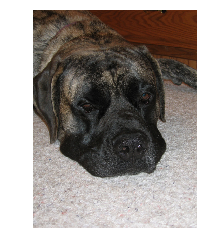

In [0]:
plt.axis('off')
plt.imshow(plt.imread(dog_files_short[10]))

In [0]:
predict_breed_transfer(dog_files_short[10])


'Entlebucher_mountain_dog'

---
<a id='step4'></a>
## Step 4: Future Scope 

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    '''
    Use pre-trained model to to check if the image at the given path
    contains a human being or a dog or none. 
    
    Args:
        img_path: path to an image
        
    Returns:
        print if a human face is detected or not
        print the dog breed or show that neither human face nor a dog detected 
    '''
    plt.axis('off')
    plt.imshow(plt.imread(img_path))
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    if(is_human):
        print("Human Face detected")
        print("It looks like the dog "+predict_breed_transfer(img_path))
        return
    elif(is_dog):
        print("It looks like the dog is of breed "+predict_breed_transfer(img_path))
        return
    else:
        print("Neither a human nor a dog")
        return
